In [1]:
# 0. Install dependencies
!pip install -q numpy==1.26.4
!pip install -q torch==2.2.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv \
              -f https://data.pyg.org/whl/torch-2.2.0+cpu.html


In [2]:
# 1. Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')       

EMB_PATH = "/content/drive/MyDrive/ml100k_embeddings/item_title_embeddings.npy"  # Path to the npy file


Mounted at /content/drive


In [3]:
# 2. Imports and dataset path
import os, urllib.request, zipfile, pandas as pd, torch, numpy as np
from torch_geometric.data import HeteroData

DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
DATA_DIR = "ml-100k"


In [4]:
# 3. Download and extract MovieLens100k
if not os.path.exists(DATA_DIR):
    urllib.request.urlretrieve(DATA_URL, "ml-100k.zip")
    zipfile.ZipFile("ml-100k.zip").extractall(".")
    os.remove("ml-100k.zip")


In [5]:
# 4. Read raw tables
ratings = pd.read_csv(f"{DATA_DIR}/u.data", sep="\t",
                      names=["user_id","item_id","rating","timestamp"])
users   = pd.read_csv(f"{DATA_DIR}/u.user", sep="|",
                      names=["user_id","age","gender","occupation","zip"])
items   = pd.read_csv(f"{DATA_DIR}/u.item", sep="|", encoding="latin-1",
                      names=["item_id","title","release","video","imdb"] + [f"g{i}" for i in range(19)])


In [6]:
# 5. Load title embeddings and align with item_id
title_emb = np.load(EMB_PATH)                    # [1682 × 1024]

items_sorted = items.sort_values("item_id").reset_index(drop=True)
assert len(items_sorted)==title_emb.shape[0], "Mismatch between number of embeddings and items"

items = items_sorted          


In [7]:
# 6. Map IDs to continuous indices
user_map = {u:i for i,u in enumerate(sorted(users.user_id.unique()))}
item_map = {v:i for i,v in enumerate(sorted(items.item_id.unique()))}

ratings["u_idx"] = ratings.user_id.map(user_map)
ratings["v_idx"] = ratings.item_id.map(item_map)
users["u_idx"]   = users.user_id.map(user_map)
items["v_idx"]   = items.item_id.map(item_map)


In [8]:
# 7. Build node features
# 7a. User features
age_norm = ((users.age - users.age.mean()) / users.age.std()).astype("float32")
gender_ohe = pd.get_dummies(users.gender,     dtype="float32")
occ_ohe    = pd.get_dummies(users.occupation, dtype="float32")

user_feat_df = pd.concat([age_norm.rename("age_norm"), gender_ohe, occ_ohe], axis=1).astype("float32")
user_feat = torch.tensor(user_feat_df.values, dtype=torch.float32)      # [943 × 24]

# 7b. Item features
# 7b-1. Binary genres (19 dimensions)
genre_feat = items[[f"g{i}" for i in range(19)]].astype("float32").values         # (1682,19)

# 7b-2. Release year (numeric feature)
def extract_year(s):
    try:
        return int(str(s)[-4:])
    except:      # empty or invalid string
        return np.nan

years = items.release.apply(extract_year).astype("float32")
years.fillna(years.median(), inplace=True)
year_norm = ((years - years.mean()) / years.std()).values[:,None]                # (1682,1)

# 7b-3. Title embedding (1024 dimensions)
emb_feat = title_emb.astype("float32")                                           # (1682,1024)

# 7b-4. Final combination
item_feat_np = np.hstack([genre_feat, year_norm, emb_feat])        # (1682, 19+1+1024 = 1044)
item_feat = torch.tensor(item_feat_np, dtype=torch.float32)
print("Item feature dim =", item_feat.shape[1])        # Expected: 1044


Item feature dim = 1044


In [9]:
# 8. Build the base HeteroData object
data = HeteroData()
data["user"].x = user_feat                 # [943 × 24]
data["item"].x = item_feat                 # [1682 × 1044]

src = torch.tensor(ratings.u_idx.values, dtype=torch.long)
dst = torch.tensor(ratings.v_idx.values, dtype=torch.long)

data["user","Rank","item"].edge_index = torch.stack([src,dst])
data["user","Rank","item"].rating     = torch.tensor(ratings.rating.values,    dtype=torch.float32)
data["user","Rank","item"].timestamp  = torch.tensor(ratings.timestamp.values, dtype=torch.float32)

# Reverse
data["item","BeRanked","user"].edge_index = torch.stack([dst,src])
data["item","BeRanked","user"].rating     = data["user","Rank","item"].rating
data["item","BeRanked","user"].timestamp  = data["user","Rank","item"].timestamp


In [10]:
# 9. Create train / test masks for rating edges
num_edges = ratings.shape[0]
test_size = 5_000
rng       = np.random.default_rng(seed=42)

test_mask_np = np.zeros(num_edges, dtype=bool)
test_mask_np[rng.choice(num_edges, size=test_size, replace=False)] = True
train_mask_np = ~test_mask_np

for rel in [("user","Rank","item"), ("item","BeRanked","user")]:
    data[rel].test_mask  = torch.tensor(test_mask_np)
    data[rel].train_mask = torch.tensor(train_mask_np)


In [11]:
# 10. Save the base graph
torch.save(data, "ml100k_step1_with_title_and_year.pt")
print(data)


HeteroData(
  user={ x=[943, 24] },
  item={ x=[1682, 1044] },
  (user, Rank, item)={
    edge_index=[2, 100000],
    rating=[100000],
    timestamp=[100000],
    test_mask=[100000],
    train_mask=[100000],
  },
  (item, BeRanked, user)={
    edge_index=[2, 100000],
    rating=[100000],
    timestamp=[100000],
    test_mask=[100000],
    train_mask=[100000],
  }
)


In [12]:
# 11. Compute rating matrix (pivot) for Pearson similarity
import pandas as pd, numpy as np, torch
from torch_geometric.data import HeteroData

data = torch.load("ml100k_step1_with_title_and_year.pt")

pivot = ratings.pivot(index="u_idx", columns="v_idx", values="rating").astype("float32")  # (943×1682)


In [13]:
# 12. User–User similarity (Pearson) and add UserSim edges
user_corr = pivot.T.corr(method="pearson", min_periods=2)
TH_U = 0.95
mat = user_corr.values
mask = (mat >= TH_U) & ~np.eye(mat.shape[0],dtype=bool) & ~np.isnan(mat)

src_u, dst_u = np.where(mask)
w = mat[src_u, dst_u].astype("float32")

edges = np.concatenate([np.stack([src_u,dst_u],1),
                        np.stack([dst_u,src_u],1)], axis=0)
weights = np.concatenate([w,w],axis=0)

data["user","UserSim","user"].edge_index = torch.tensor(edges.T, dtype=torch.long)
data["user","UserSim","user"].weight     = torch.tensor(weights, dtype=torch.float32)
print("UserSim edges:", edges.shape[0])


UserSim edges: 42872


In [14]:
# 13. Item–Item similarity (Pearson) with updated features
# Use pivot for correlation as before
item_corr = pivot.corr(method="pearson", min_periods=2)
TH_I = 0.95
mat_i = item_corr.values
mask_i = (mat_i >= TH_I) & ~np.eye(mat_i.shape[0],dtype=bool) & ~np.isnan(mat_i)

src_i, dst_i = np.where(mask_i)
w_i = mat_i[src_i, dst_i].astype("float32")

edges_i = np.concatenate([np.stack([src_i,dst_i],1),
                          np.stack([dst_i,src_i],1)], axis=0)
weights_i = np.concatenate([w_i,w_i],axis=0)

data["item","ItemSim","item"].edge_index = torch.tensor(edges_i.T, dtype=torch.long)
data["item","ItemSim","item"].weight     = torch.tensor(weights_i, dtype=torch.float32)
print("ItemSim edges:", edges_i.shape[0])


ItemSim edges: 256448


In [15]:
# 14. Save the graph with similarity edges
torch.save(data, "ml100k_step2_with_similarity.pt")
print("Saved ⇒ ml100k_step2_with_similarity.pt")


Saved ⇒ ml100k_step2_with_similarity.pt


In [16]:
# 15. Reduce title embedding dimensions to 256 with PCA
from sklearn.decomposition import PCA
import numpy as np
import torch

data = torch.load("ml100k_step2_with_similarity.pt")

# Extract item features 
item_feats = data["item"].x.numpy()           # shape: (1682, 1044)

# Separate genre + year (first 20 dims) and title embedding (last 1024 dims)
static_feats = item_feats[:, :20]              # (1682, 20)
emb_feats    = item_feats[:, 20:]              # (1682, 1024)

# Run PCA to reduce embedding dimensions to 256
pca = PCA(n_components=256, random_state=42)
emb_reduced = pca.fit_transform(emb_feats)     # (1682, 256)

# Recombine features
new_item_feats = np.hstack([static_feats, emb_reduced])  # (1682, 20+256 = 276)

# Update graph and save as new version
data["item"].x = torch.tensor(new_item_feats, dtype=torch.float32)
torch.save(data, "ml100k_step2_with_similarity_reduced256.pt")
print("Title embeddings reduced to 256 dims. New item.x shape:", data["item"].x.shape)
print("Saved ⇒ ml100k_step2_with_similarity_reduced256.pt")


Title embeddings reduced to 256 dims. New item.x shape: torch.Size([1682, 276])
Saved ⇒ ml100k_step2_with_similarity_reduced256.pt


In [19]:
# 15. Clustering users and items (with new item features)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

data = torch.load("ml100k_step2_with_similarity_reduced256.pt")

# Standardize features
U_std = StandardScaler().fit_transform(data["user"].x.numpy())
V_std = StandardScaler().fit_transform(data["item"].x.numpy())

# Search for K 
def k_search(mat_std, k_range):
    inert, sil = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=20, random_state=0).fit(mat_std)
        inert.append(km.inertia_)
        sil.append(np.nan if k==1 else silhouette_score(mat_std, km.labels_))
    return inert, sil


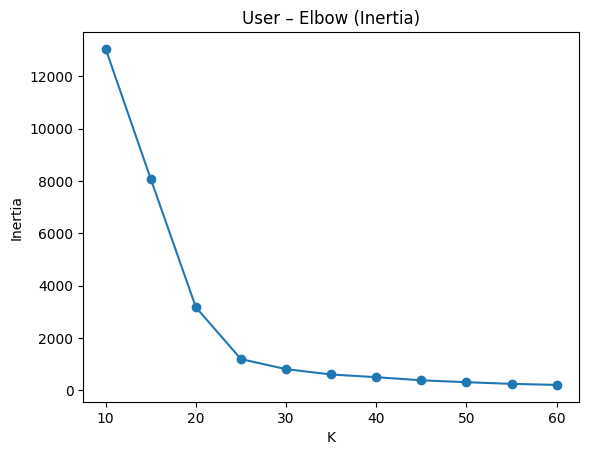

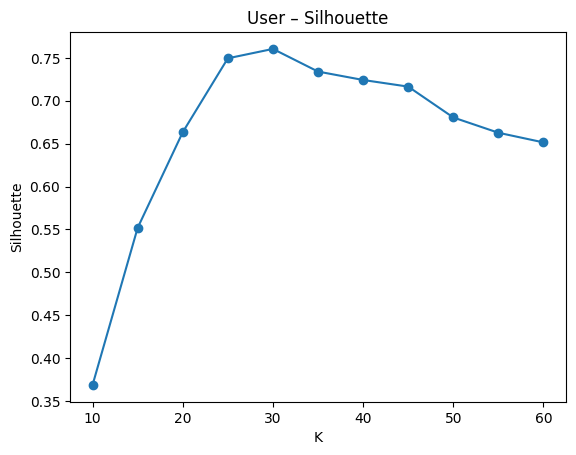

In [20]:
# elbow & silhouette for USER clusters
Ku_range = np.arange(10, 61, 5)               
inertia_u, sil_u = k_search(U_std, Ku_range)

plt.figure()
plt.plot(Ku_range, inertia_u, marker='o')
plt.title("User – Elbow (Inertia)"); plt.xlabel("K"); plt.ylabel("Inertia"); plt.show()

plt.figure()
plt.plot(Ku_range, sil_u, marker='o')
plt.title("User – Silhouette"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.show()


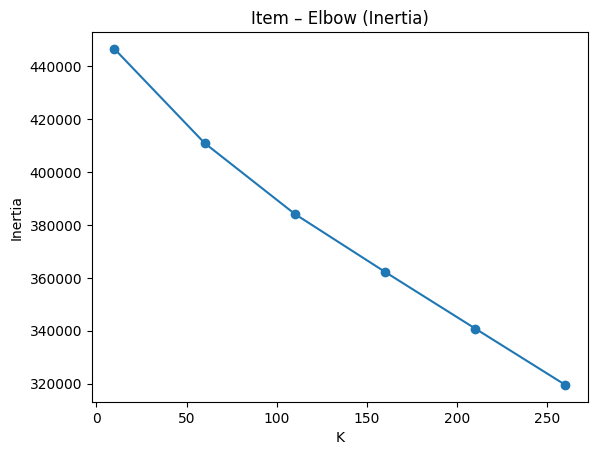

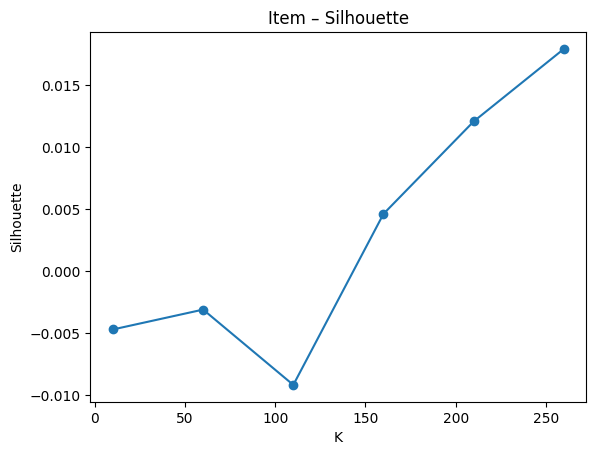

In [21]:
# elbow & silhouette for ITEM clusters
Kv_range = np.arange(10, 300, 50)
inertia_v, sil_v = k_search(V_std, Kv_range)

plt.figure()
plt.plot(Kv_range, inertia_v, marker='o')
plt.title("Item – Elbow (Inertia)"); plt.xlabel("K"); plt.ylabel("Inertia"); plt.show()

plt.figure()
plt.plot(Kv_range, sil_v, marker='o')
plt.title("Item – Silhouette"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.show()


In [22]:
K_U_CHOSEN = 30
K_V_CHOSEN = 200


In [23]:
# Run KMeans and add super-nodes + membership edges 
# Users
km_u = KMeans(n_clusters=K_U_CHOSEN, n_init=50, random_state=42).fit(U_std)
cu_centers, cu_labels = km_u.cluster_centers_, km_u.labels_

# Items
km_v = KMeans(n_clusters=K_V_CHOSEN, n_init=50, random_state=42).fit(V_std)
cv_centers, cv_labels = km_v.cluster_centers_, km_v.labels_

# Add cluster nodes
data["user_cluster"].x = torch.tensor(cu_centers, dtype=torch.float32)
data["item_cluster"].x = torch.tensor(cv_centers, dtype=torch.float32)

# Membership edges (user → cluster)
sim_u = cosine_similarity(U_std, cu_centers)
u2c_w = sim_u[np.arange(len(cu_labels)), cu_labels]

u_src = torch.arange(len(cu_labels), dtype=torch.long)
u_dst = torch.tensor(cu_labels, dtype=torch.long)

data["user","memberOf","user_cluster"].edge_index = torch.stack([u_src,u_dst])
data["user","memberOf","user_cluster"].weight     = torch.tensor(u2c_w, dtype=torch.float32)
data["user_cluster","contains","user"].edge_index = torch.stack([u_dst,u_src])
data["user_cluster","contains","user"].weight     = torch.tensor(u2c_w, dtype=torch.float32)

# Membership edges (item → cluster)
sim_v = cosine_similarity(V_std, cv_centers)
v2c_w = sim_v[np.arange(len(cv_labels)), cv_labels]

v_src = torch.arange(len(cv_labels), dtype=torch.long)
v_dst = torch.tensor(cv_labels, dtype=torch.long)

data["item","memberOf","item_cluster"].edge_index = torch.stack([v_src,v_dst])
data["item","memberOf","item_cluster"].weight     = torch.tensor(v2c_w, dtype=torch.float32)
data["item_cluster","contains","item"].edge_index = torch.stack([v_dst,v_src])
data["item_cluster","contains","item"].weight     = torch.tensor(v2c_w, dtype=torch.float32)

print("Clusters & membership edges added.")


Clusters & membership edges added.


In [24]:
# 16. Save the final graph 
torch.save(data, "ml100k_step3_full_graph.pt")
print("Saved ⇒ ml100k_step3_full_graph.pt")
print(data)


Saved ⇒ ml100k_step3_full_graph.pt
HeteroData(
  user={ x=[943, 24] },
  item={ x=[1682, 276] },
  user_cluster={ x=[30, 24] },
  item_cluster={ x=[200, 276] },
  (user, Rank, item)={
    edge_index=[2, 100000],
    rating=[100000],
    timestamp=[100000],
    test_mask=[100000],
    train_mask=[100000],
  },
  (item, BeRanked, user)={
    edge_index=[2, 100000],
    rating=[100000],
    timestamp=[100000],
    test_mask=[100000],
    train_mask=[100000],
  },
  (user, UserSim, user)={
    edge_index=[2, 42872],
    weight=[42872],
  },
  (item, ItemSim, item)={
    edge_index=[2, 256448],
    weight=[256448],
  },
  (user, memberOf, user_cluster)={
    edge_index=[2, 943],
    weight=[943],
  },
  (user_cluster, contains, user)={
    edge_index=[2, 943],
    weight=[943],
  },
  (item, memberOf, item_cluster)={
    edge_index=[2, 1682],
    weight=[1682],
  },
  (item_cluster, contains, item)={
    edge_index=[2, 1682],
    weight=[1682],
  }
)


In [25]:
# 17. Save the final graph to Google Drive
import os, torch

DRIVE_DIR = "/content/drive/MyDrive/ml100k_graphs"
os.makedirs(DRIVE_DIR, exist_ok=True)

data = torch.load("ml100k_step3_full_graph.pt")

# Save to Drive
SAVE_PATH = os.path.join(DRIVE_DIR, "ml100k_step3_full_graph.pt")
torch.save(data, SAVE_PATH)

print(f"Full heterogeneous graph saved to:\n{SAVE_PATH}")


Full heterogeneous graph saved to:
/content/drive/MyDrive/ml100k_graphs/ml100k_step3_full_graph.pt
